In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install tensorflow

In [2]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [4]:
import zipfile
import os

# Unzip the file
with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('archive (1)')

# Explore the contents of the unzipped folder
os.listdir('archive (1)/Data')

['test', 'train', 'valid']

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to the data directories
train_dir = '/content/archive (1)/Data/train'
val_dir = '/content/archive (1)/Data/valid'
test_dir = '/content/archive (1)/Data/test'

# Data augmentation and preprocessing for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Reduced from 40
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing for validation and test sets (without augmentation)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)  # Extra dense layer
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

# Freeze initial layers to retain ImageNet knowledge
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
class_weights = {0: 1.0, 1: 1.5, 2: 1.2, 3: 2.0}  # Example weights
model.fit(train_generator, validation_data=val_generator, epochs=20, class_weight=class_weights)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 312s 14s/step - accuracy: 0.3766 - loss: 2.3111 - val_accuracy: 0.3194 - val_loss: 319.1308
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 301s 13s/step - accuracy: 0.5149 - loss: 1.3634 - val_accuracy: 0.4722 - val_loss: 19.8786
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 324s 13s/step - accuracy: 0.5800 - loss: 1.3712 - val_accuracy: 0.3611 - val_loss: 5.4294
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 321s 13s/step - accuracy: 0.5346 - loss: 1.2938 - val_accuracy: 0.3889 - val_loss: 7.3402
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 268s 13s/step - accuracy: 0.6108 - loss: 1.2965 - val_accuracy: 0.2083 - val_loss: 8.9149
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 269s 13s/step - accuracy: 0.5321 - loss: 1.2896 - val_accuracy: 0.3889 - val_loss: 6.5145
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 269s 13s/step - accuracy: 0.5229 - loss: 1.2713 - val_accuracy: 0.3750 - val_loss: 3.0674
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 321s 13s/step - accuracy: 0.5328 - loss: 1.3242 - val_accuracy: 0.3889 - v

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


model evaluation

In [ ]:
# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions back to class labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Display predicted vs true labels for a sample
for i in range(10):
    print(f"Image {i+1}: True Label: {class_labels[true_classes[i]]}, Predicted: {class_labels[predicted_classes[i]]}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Image 1: True Label: adenocarcinoma, Predicted: normal
Image 2: True Label: adenocarcinoma, Predicted: normal
Image 3: True Label: adenocarcinoma, Predicted: normal
Image 4: True Label: adenocarcinoma, Predicted: adenocarcinoma
Image 5: True Label: adenocarcinoma, Predicted: adenocarcinoma
Image 6: True Label: adenocarcinoma, Predicted: normal
Image 7: True Label: adenocarcinoma, Predicted: adenocarcinoma
Image 8: True Label: adenocarcinoma, Predicted: normal
Image 9: True Label: adenocarcinoma, Predicted: adenocarcinoma
Image 10: True Label: adenocarcinoma, Predicted: adenocarcinoma


visualisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


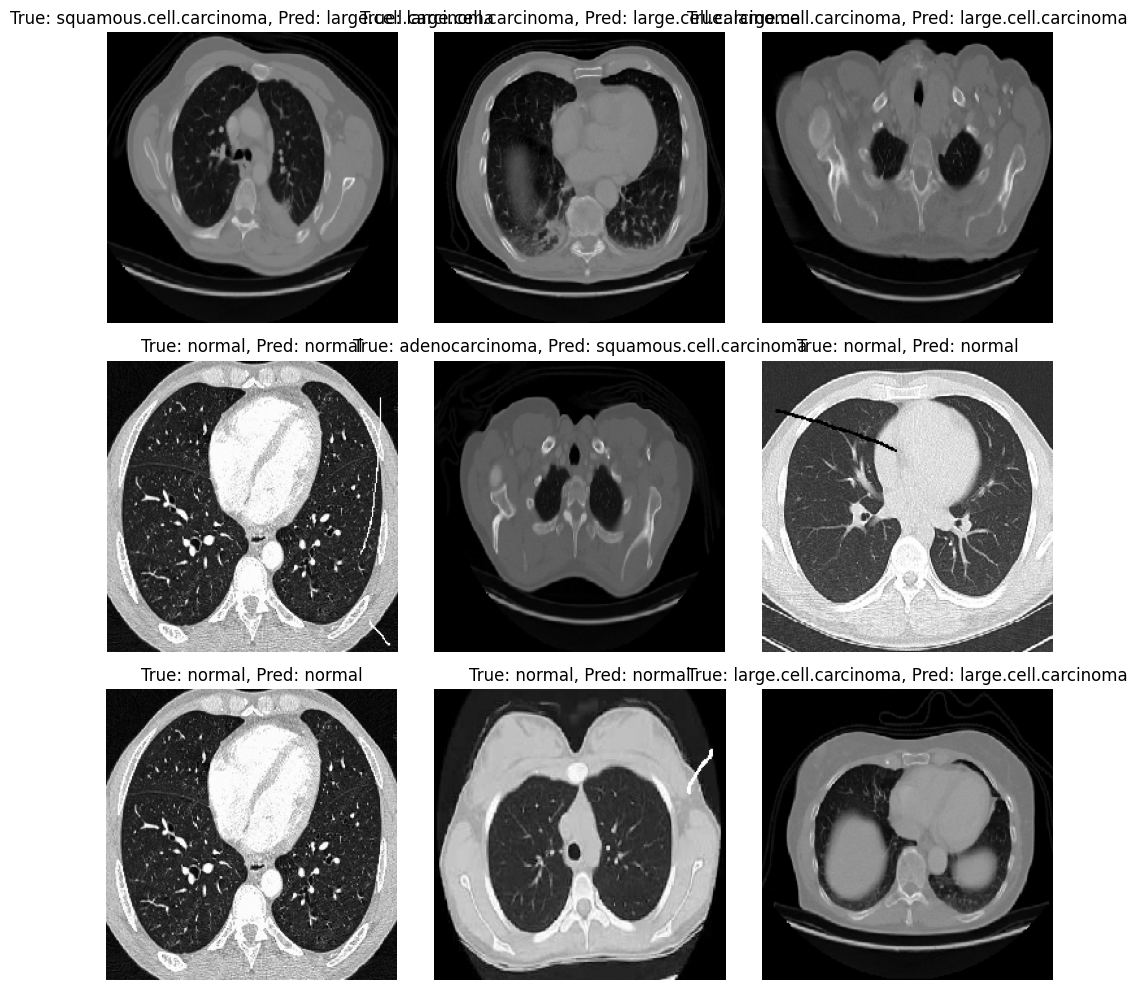

In [ ]:
# Get a batch of images from the test set
test_images, test_labels = next(test_generator)

# Predict the labels for this batch
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot the first 9 images from the batch with their predicted and true labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    true_label = class_labels[np.argmax(test_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

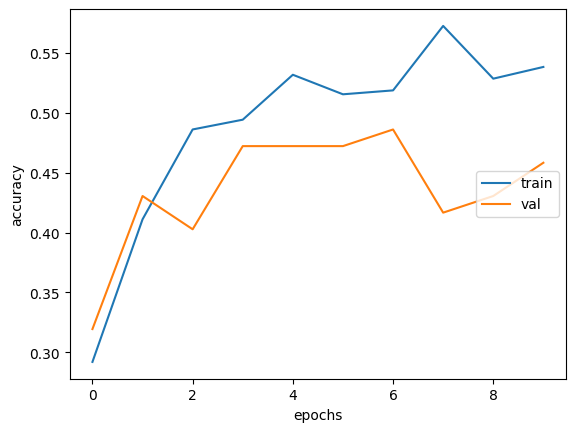

In [ ]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Class Distribution:
Class 0: 195 images
Class 1: 115 images
Class 2: 148 images
Class 3: 155 images


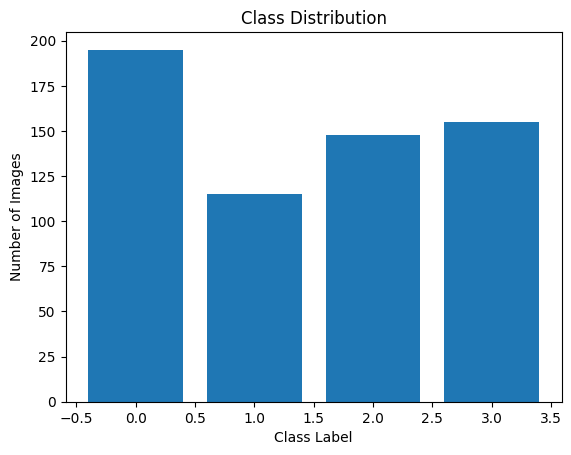

In [ ]:
# Class distribution
class_counts = train_generator.classes
unique, counts = np.unique(class_counts, return_counts=True)

print("Class Distribution:")
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} images")

# Optional: Plot the class distribution
import matplotlib.pyplot as plt

plt.bar(unique, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()
